# Using Linear Regression to Predict MLB Wins By a Team's Statistics

In the notebook we are going to use statistics from every 162 game MLB season to draw a relationship between a team's statistics and their total wins. Ultiately we will use this information to extrapolate over the covid-truncated 2020 team statistics to determine which teams benefitted from the shortened season.

### Import everything

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
%config InlineBackend.figure_formats = ['svg']
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## Data
I sourced my data from [Baseball Reference]("https://www.baseball-reference.com/") using BeautifulSoup and Selenium to scrape. That process can be found in my [scraping file](Team_Season_Data_Scraping.ipynb). I pickled the data as dataframes and will be importing and unpickling in this notebook.

## Target and Features 

In very basic terms linear regression models "take in" features and try to predict a target. <br>
In this case our target is easy - the number of wins a team has in a season. <br>
For our features we will start by analyzing what I will call the "Pure Statistics". These are the "building blocks" of baseball. While they all will have a relationship with runs scored, and wins, none of them on their own (with the exception of home runs) actually produce any runs.

- PA (Plate Appearances) 
- 1B (Singles)
- 2B (Doubles)
- 3B (Triples)
- HR (Home Runs)
- BB (Walks)
- SB (Stolen Bases)
- SO (StrikeOuts)

> Note: We will also be looking at how teams GAVE UP these stats. So we will have two of each of the stats, stats for a team and stats AGAINST a team.. 

# Pure Stats Model

In [17]:
# The stats columns we will want for our dataframes
pure_stats = ['W', 'G', 'PA', '1B', '2B', '3B', 'HR','BB', 'SB', 'SO']
pure_stats_against = ['PA_A', '1B_A', '2B_A', '3B_A', 'HR_A','BB_A', 'SB_A', 'SO_A']

In [18]:
complete_df = pd.read_pickle("full_comined_baseball_stats.pkl")
complete_df.columns
complete_df[(complete_df["Team"] == "MIL") & (complete_df["Year"] == 1962)].head()

,Year,Team,W,G,PA,1B,2B,3B,HR,BB,SB,SO,BA,OBP,SLG,PA_A,1B_A,2B_A,3B_A,HR_A,BB_A,SB_A,SO_A,BA_A,OBP_A,SLG_A


In [19]:
# grab all the seasons that have 162 games (a full season)
all_games = complete_df[complete_df['G']==162].reset_index(drop=True)
print(all_games.shape)
# split off 20 percent for final testing
all_games, test_seasons = train_test_split(all_games, test_size=.2)

(1150, 26)


In [20]:
# This is what our data looks like
all_games

,Year,Team,W,G,PA,1B,2B,3B,HR,BB,SB,SO,BA,OBP,SLG,PA_A,1B_A,2B_A,3B_A,HR_A,BB_A,SB_A,SO_A,BA_A,OBP_A,SLG_A
178,1974,CHC,66,162,39.2,6.32,1.36,0.26,0.68,3.83,0.48,5.29,0.251,0.327,0.365,40.234568,7.413580,1.407407,0.259259,0.753086,3.555556,0.777778,5.524691,0.277,0.344,0.396
289,1993,CLE,76,162,38.7,6.86,1.63,0.19,0.87,3.01,0.98,5.20,0.275,0.335,0.409,39.407407,6.851852,1.716049,0.129630,1.123457,3.648148,0.697531,5.481481,0.281,0.351,0.434
491,1984,ANA,81,162,38.1,5.99,1.30,0.19,0.93,3.43,0.49,5.73,0.249,0.319,0.381,38.481481,6.765432,1.580247,0.191358,0.882716,2.925926,0.438272,4.654321,0.271,0.328,0.404
550,1966,LAD,95,162,37.5,6.56,1.24,0.17,0.67,2.65,0.58,5.12,0.256,0.314,0.362,36.672840,6.259259,1.030864,0.135802,0.518519,2.197531,0.333333,6.691358,0.237,0.286,0.323
486,1989,ANA,91,162,37.7,6.37,1.28,0.23,0.90,2.65,0.55,6.24,0.256,0.311,0.386,37.456790,6.469136,1.240741,0.135802,0.697531,2.870370,0.685185,5.537037,0.253,0.312,0.360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,1977,LAD,98,162,39.1,6.43,1.38,0.17,1.18,3.63,0.70,5.53,0.266,0.336,0.418,37.790123,6.271605,1.407407,0.185185,0.734568,2.703704,0.666667,5.740741,0.251,0.308,0.368
950,2012,SEA,75,162,37.4,5.35,1.49,0.17,0.92,2.88,0.64,7.77,0.234,0.296,0.369,37.419753,5.672840,1.518519,0.172840,1.024691,2.771605,0.790123,7.197531,0.248,0.308,0.394
711,1991,NYY,71,162,37.9,6.18,1.54,0.12,0.91,2.92,0.67,5.31,0.256,0.316,0.387,38.327160,6.302469,1.820988,0.259259,0.938272,3.123457,0.827160,5.777778,0.271,0.334,0.421
796,1992,PHI,70,162,38.1,6.07,1.57,0.22,0.73,3.14,0.78,6.54,0.253,0.320,0.377,37.734568,5.981481,1.623457,0.259259,0.697531,3.388889,0.685185,5.253086,0.257,0.326,0.384


In [21]:
pd.set_option('display.max_columns', None)
all_games[(all_games["Team"] == "MIL") & (all_games["Year"] == 1962)].head()

,Year,Team,W,G,PA,1B,2B,3B,HR,BB,SB,SO,BA,OBP,SLG,PA_A,1B_A,2B_A,3B_A,HR_A,BB_A,SB_A,SO_A,BA_A,OBP_A,SLG_A


### Lets look at the correlations

In [22]:
# The combined features we will be examining
combined_features = ['PA', '1B', '2B', '3B', 'HR','BB', 'SB', 'SO', 
                     'PA_A', '1B_A', '2B_A', '3B_A', 'HR_A','BB_A', 'SB_A', 'SO_A']

In [23]:
all_games[['W'] + combined_features].corr()[['W']]

,W
W,1.000000
PA,0.408654
1B,0.153787
2B,0.202114
3B,0.025495
HR,0.298063
BB,0.386577
SB,0.121552
SO,-0.085953
PA_A,-0.479296


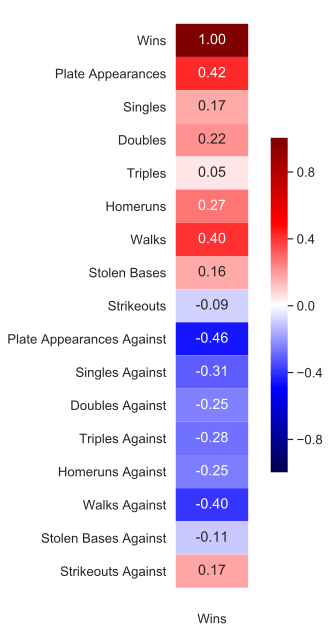

In [9]:
# plot heat map of pure stats compared to wins
y_axis_labels = ["Wins", "Plate Appearances", "Singles", "Doubles", "Triples", "Homeruns", "Walks", "Stolen Bases", "Strikeouts",
                 "Plate Appearances Against", "Singles Against", "Doubles Against", "Triples Against", "Homeruns Against", "Walks Against", "Stolen Bases Against", "Strikeouts Against"]
f, ax = plt.subplots(figsize=(2, 11))
ax = sns.heatmap(all_games[['W'] + combined_features].corr()[['W']], cmap="seismic", annot=True, vmin=-1, vmax=1,  
                 fmt=".2f", yticklabels=y_axis_labels, xticklabels=["Wins"],
                cbar_kws = dict(pad=.2), )
ax.set_ylim(len(all_games[['W'] + combined_features].corr()[['W']])+.5, -.5)
plt.yticks(rotation=0);
# plt.savefig('pure_stats_corr.png', bbox_inches = "tight", dpi=500);

Right off the bat it looks like everything that should be positively correlated is while everything that should be negatively correlated is indeed negatively correlated. Its interesting to note the heavy correlation between Walks and wins.

In [ ]:
# Next we can look at the pairplots to see if we find any interesting relationships
sns.pairplot(all_games[pure_stats]);

There is nothing that jumps off the page there as needing a transformation. Plate Appearences appear to have a linear relationship with lots of the other features, this may cause issues. We will keep that in mind as we hop into our linear regression.

## Least Squares Model
We will start by looking at a simple least squares model

In [24]:
# Lets first make a function to create models

def linear_create_validate(features, target, random_state=None):
    """
    Takes a features dataframe and a target data frame as inputs
    Returns the fitted model and the linear regression model
    """
    
    # create the training and validation sets
    features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=.25, random_state=random_state)
    
    # set up the model and fir it with training set
    lr = LinearRegression()
    model = lr.fit(features_train, target_train)
    
    # check the score on the validation set
    val_score = lr.score(features_val, target_val)
    print("Validate Score: ", val_score)
    
    # check the score on the training set
    training_score = lr.score(features_train, target_train)
    print("Training Score: ", training_score)
    
    # run on the hold out test set
    predicted_vals = model.predict(features_val)
    
    return({
        "Model": model, 
        "LR": lr, 
        "Predicted": predicted_vals, 
        "Actual": target_val
    })

In [25]:
# set the features and target
features = all_games[combined_features]
target = all_games['W']

In [26]:
linear_model_dict = linear_create_validate(features, target, random_state=10)

Validate Score:  0.8176179316700612
Training Score:  0.813875329053638


If you run the above cell a few times you will see that our validation scores and training scores both hover right around the low .8's <br>
The fact that neither is consistently higher than the other tells us that our model is probably not over or under fitting. IE no lasso/ridge/polynomial needed

Lets now scale the data to see how important each feature is

In [27]:
# scale the data
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)

In [28]:
# feed the scaled features into the function
scaled_model_dict = linear_create_validate(scaled_features, target, random_state=10)

Validate Score:  0.8176179316700611
Training Score:  0.8138753290536379


Good news is that the scores have not changed, so we can be confident we scaled correctly. (Scaling should not affect scores) <br>
Lets take a look at the coefficents

In [15]:
# print out the coefficents with the corresponding feature
for c in zip( combined_features, scaled_model_dict["LR"].coef_):
    print(c[0], c[1])

PA -2.6422677376443375
1B 5.202099128845612
2B 3.5208580438489196
3B 1.1615767044401064
HR 6.841052581600259
BB 4.1385757666077305
SB 1.1395546794270057
SO -0.3039995752322079
PA_A 3.106502405775345
1B_A -5.0875980834276975
2B_A -4.160356574203083
3B_A -1.4024614299869904
HR_A -6.054136901622486
BB_A -4.5061483079088775
SB_A -0.9285338789576735
SO_A 0.2650466521808602


We notice something odd with Plate Appearences here. They seem to be working opposite as they should. Plate appearences appears NEGATIVELY correlated with wins while plate appearences against appears POSITIVELY correlated with wins. I suspect this is due to Plate Appearences being colinear with nearly every other statistic. Let's toss it and see what happens.

## Remove Plate Appearence Feature

In [29]:
# The combined features without plate appearence
combined_features_nopa = ['1B', '2B', '3B', 'HR','BB', 'SB', 'SO', 
                     '1B_A', '2B_A', '3B_A', 'HR_A','BB_A', 'SB_A', 'SO_A']

In [30]:
# set the features and target
features = all_games[combined_features_nopa]
target = all_games['W']

In [31]:
linear_model_nopa_dict = linear_create_validate(features, target, random_state=8)

Validate Score:  0.8236283370058084
Training Score:  0.8019459029734143


It appears as though taking out the plate appearences did not affect our model's score. Thats good news.

## Analyze Residuals

In [19]:
# Find our residuals for data our model has never seen
precicted_wins = linear_model_nopa_dict["Predicted"]
actual_wins = linear_model_nopa_dict["Actual"]
win_diff = precicted_wins - actual_wins

In [20]:
# we see that our model is on average within about 4 wins... not bad
win_diff.abs().describe()

count    230.000000
mean       4.038366
std        2.905646
min        0.027212
25%        1.763613
50%        3.592219
75%        5.737457
max       15.854491
Name: W, dtype: float64

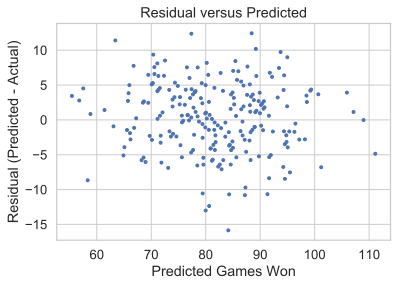

In [21]:
# plot the residuals
plt.xlabel('Predicted Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Predicted')
plt.plot(precicted_wins, win_diff, '.');

We can see that our residuals are pretty evenly distrubted when compared to their predictions. Thats a good sign. However when we plot the residuals with respect to the actual values we see an issue...

In [22]:
lr = LinearRegression()
fit_model = lr.fit(actual_wins.values.reshape(-1, 1), win_diff)
lr.coef_, lr.intercept_

(array([-0.21695622]), 17.99034714091767)

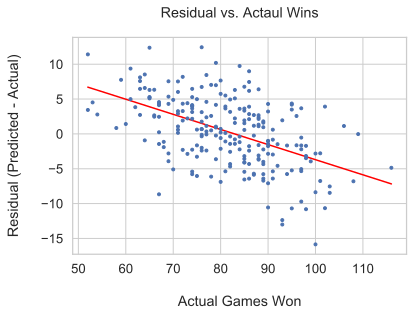

In [23]:
# plot the residuals
plt.xlabel('Actual Games Won', labelpad=20)
plt.ylabel('Residual (Predicted - Actual)', labelpad=20)
plt.title('Residual vs. Actaul Wins', pad =20)
plt.plot(actual_wins,fit_model.predict(actual_wins.values.reshape(-1, 1)), color="red")
plt.plot(actual_wins, win_diff, '.')
plt.savefig('residuals_pure_1.png', bbox_inches = "tight", dpi=500);

### Little Issue
When plotted versus their ACTUAL wins we can see that the residuals actually have a negative trend. <br>
### What this means
This tells me that our model over predicts worse teams and under predicts the better teams. Let's see if we can fix this.

# Feature Engineering
So far we have just been analyzing the "Pure Statistics", and have created a pretty good linear model. But we can also "engineer" these features to gather more insight. We will begin with a Polynomial interpotation. 

In [24]:
# Lets first make a function to create models

def polynomial_create_validate(features, target):
    """
    Takes a features dataframe and a target data frame as inputs
    Returns the fitted model and the polynomial regression model
    """
    
    # create the training and validation sets
    features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=.25)
    
    poly = PolynomialFeatures(degree=2)
    features_train_poly = poly.fit_transform(features_train)
    features_val_poly = poly.transform(features_val)
    
    
    
    # set up the model and fit it with training set
    lr = LinearRegression()
    model = lr.fit(features_train_poly, target_train)
    
    # check the score on the validation set
    val_score = lr.score(features_val_poly, target_val)
    print("Validate Score: ", val_score)
    
    # check the score on the training set
    training_score = lr.score(features_train_poly, target_train)
    print("Training Score: ", training_score)
    
    # run on the hold out test set
    predicted_vals = model.predict(features_val_poly)
    
    return({
        "Model": model, 
        "LR": lr, 
        "Predicted": predicted_vals, 
        "Actual": target_val
    })

In [25]:
# Lets first make a function to create models

def polynomial_ridge_create_validate(features, target, alphas=(.1, 1, 10)):
    """
    Takes a features dataframe and a target data frame as inputs
    Returns the fitted model and the polynomial regression model
    """
    
    # create the training and validation sets
    features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=.25)
    
    poly = PolynomialFeatures(degree=2)
    features_train_poly = poly.fit_transform(features_train)
    features_val_poly = poly.transform(features_val)
    
    std = StandardScaler()
    train_poly_scale = std.fit_transform(features_train_poly)
    val_poly_scale = std.transform(features_val_poly)

    
    # set up the model and fit it with training set
    lr_ridge = RidgeCV(alphas = alphas)
    model = lr_ridge.fit(train_poly_scale, target_train)
    
    print("Alpha: ", lr_ridge.alpha_)
    
    # check the score on the validation set
    val_score = lr_ridge.score(val_poly_scale, target_val)
    print("Validate Score: ", val_score)
    
    # check the score on the training set
    training_score = lr_ridge.score(train_poly_scale, target_train)
    print("Training Score: ", training_score)
    
    # run on the hold out test set
    predicted_vals = lr_ridge.predict(val_poly_scale)
    
    return({
        "Model": model, 
        "LR": lr_ridge, 
        "Predicted": predicted_vals, 
        "Actual": target_val
    })

# Polynomial engineering on pure stats

In [26]:
features = all_games[combined_features_nopa]
target = all_games["W"]

In [27]:
poly_pure_stats_model = polynomial_create_validate(features, target)

Validate Score:  0.7776571596340398
Training Score:  0.846433455008027


Above we are over fitting. The Training score is higher than the validation score. This means our modeling is getting really good with the trainig data, but not generalizing enough for the validation set (data it was not trained on). To "loosen" it up we will try a ridge regression.

In [28]:
poly_ridge_pure_stats_model = polynomial_ridge_create_validate(features, target, alphas=(20, 30, 40 , 50, 60))

Alpha:  50
Validate Score:  0.7708999305101056
Training Score:  0.8246611811175993


This helps the overfitting but it doesnt help the scores from the original model

In [29]:
# Find our residuals for data our model has never seen
precicted_wins = poly_ridge_pure_stats_model["Predicted"]
actual_wins = poly_ridge_pure_stats_model["Actual"]
win_diff = precicted_wins - actual_wins

In [30]:
win_diff.abs().describe()

count    230.000000
mean       4.275712
std        3.109362
min        0.043051
25%        1.755311
50%        3.696393
75%        6.015466
max       13.023737
Name: W, dtype: float64

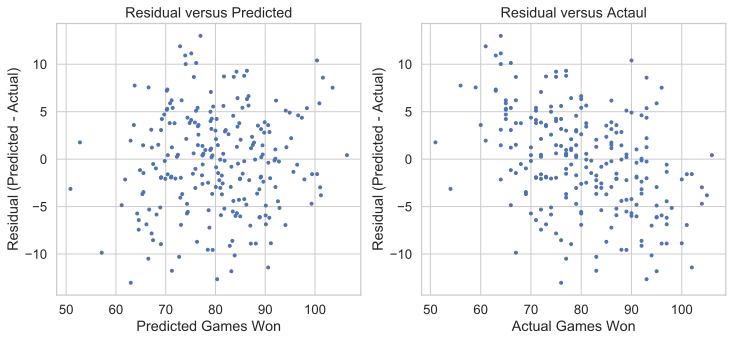

In [31]:
plt.figure(figsize=(12,5))

# plot the residuals
ax1=plt.subplot(1, 2, 1)
plt.xlabel('Predicted Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Predicted')
plt.plot(precicted_wins, win_diff, '.');

# plot the residuals
ax2=plt.subplot(1, 2, 2)
plt.xlabel('Actual Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Actaul')
plt.plot(actual_wins, win_diff, '.');

# Domain Knowledge
Baseball has a slew of commonly used statistics that are really just combinations of these "Pure Statistics", i.e. feature engineering.
I will be analyzing three common "Average Statistics" :

- BA (Batting Average) ( Hits / At-Bats )
- OBP (ON Base Percentage) ( (Hits + Walks) / Plate Appearences )
- SLG (Slugging Percentage ( (1B + 2* 2B + 3* 3B + 4* HR) / At-Bats )

In [32]:
avg_stats = ['W', 'G', 'BA', 'OBP', 'SLG']
avg_stats_against = ['BA_A', 'OBP_A', 'SLG_A']

### Lets Explore the Correlations

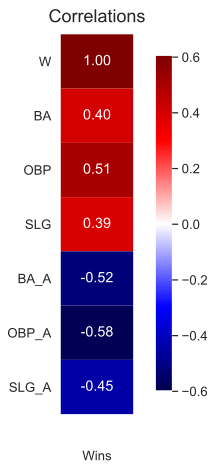

In [33]:
# lets see how the features correlate with wins
combined_features_avgs = ['BA', 'OBP', 'SLG', 'BA_A', 'OBP_A', 'SLG_A']
f, ax = plt.subplots(figsize=(2, 8))
ax = sns.heatmap(all_games[['W'] + combined_features_avgs].corr()[['W']], 
                 cmap="seismic", annot=True, vmin=-.6,  vmax=.6,  fmt=".2f", xticklabels=["Wins"],
                cbar_kws = dict(pad=.2), )
ax.set_ylim(len(all_games[['W'] + combined_features_avgs].corr()[['W']])+.5, -.5)
plt.title('Correlations', pad=-15, fontsize=18)
plt.yticks(rotation=0);

It is interesting to see how On Base Percentage is much more correlated than Batting average, as they are fairly similar statistics. The primary difference is On Base Percentage factors in walks which Batting average does not. This is consistent with our findings with the pure statistics, where walks were highly correlated with wins. (This is what money ball discovered)

In [ ]:
sns.pairplot(all_games[['W', 'BA', 'OBP', 'SLG']]);

Unsurprisingly there is a lot of collinierity going on. These averages are describing the same statistics in slightly different ways. Let's see how this affects the modelling.

## Least Squares Model
We will start again by looking at a simple least squares model

In [35]:
# set the features and target
features = all_games[combined_features_avgs]
target = all_games['W']

In [36]:
# scale the data
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)

In [37]:
# feed the scaled features into the function
scaled_model_dict_avgs = linear_create_validate(scaled_features, target)

Validate Score:  0.8358113962188842
Training Score:  0.8098550750349269


Once again our scores are hovering around the low .8's. Lets look at the coefficents

In [38]:
# print out the coefficents with the corresponding feature
for c in zip( combined_features_avgs, scaled_model_dict["LR"].coef_):
    print(c[0], c[1])

BA -2.6422677376443375
OBP 5.202099128845612
SLG 3.5208580438489196
BA_A 1.1615767044401064
OBP_A 6.841052581600259
SLG_A 4.1385757666077305


We see that our batting average coefficents are funny. Batting average is negatively correlated with wins while Batting average against is quite small. Once again this is telling me that Batting Average is very colinear with the other two stats and our model is telling us that OBP and SLugging are a better predictor. 
>This is exactly what they discovered in money ball OBP is a better predictor than Batting Average

## Remove Batting Average 

In [39]:
combined_features_noba = ['OBP', 'SLG', 'BA_A', 'OBP_A']
# set the features and target
features = all_games[combined_features_noba]
target = all_games['W']

In [40]:
# scale the data
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)

In [41]:
# feed the scaled features into the function
scaled_model_dict_avgs_noba = linear_create_validate(scaled_features, target)

Validate Score:  0.7822133151117915
Training Score:  0.7755038278804617


Removing the batting average has actually hurt our model's score. It is now in the high 70's. So Let's keep it in.

## Check Residuals on Model with BA
Ok so now we have looked at feature engineered models. Our score has not really changed... But has it improved the issue we were seeing with our residuals

In [42]:
# Find our residuals for data our model has never seen
precicted_wins = scaled_model_dict_avgs["Predicted"]
actual_wins = scaled_model_dict_avgs["Actual"]
win_diff = precicted_wins - actual_wins

In [43]:
win_diff.abs().describe()

count    230.000000
mean       3.795677
std        2.631789
min        0.009014
25%        1.818325
50%        3.213018
75%        5.110708
max       12.791227
Name: W, dtype: float64

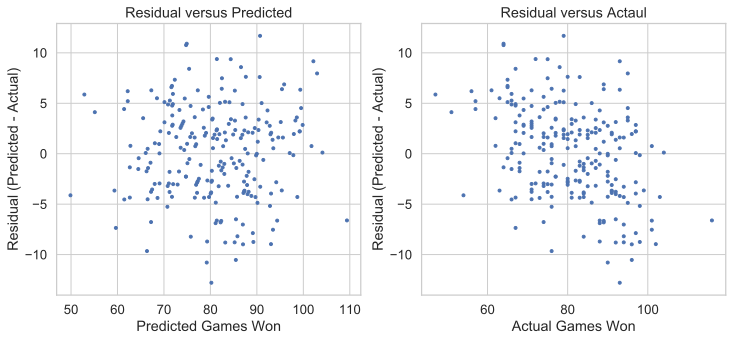

In [44]:
plt.figure(figsize=(12,5))

# plot the residuals
ax1=plt.subplot(1, 2, 1)
plt.xlabel('Predicted Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Predicted')
plt.plot(precicted_wins, win_diff, '.');

# plot the residuals
ax2=plt.subplot(1, 2, 2)
plt.xlabel('Actual Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Actaul')
plt.plot(actual_wins, win_diff, '.');

Again, we see the same issue, where the residuals trend downward as the actual games won increases. Again our model over predicts the worse teams and under predicts the better teams.

So there's not much different between the "pure stats" model and the "engineered stats" model...  

# Combined Pure and Engineered

Let's just throw the kitchen sink at this model. Add together the "Pure Stats" and the "Engineered Stats" into one model!

In [45]:
all_features = ['1B', '2B', '3B', 'HR','BB', 'SB', 'SO', 'BA','OBP', 'SLG',
                          '1B_A', '2B_A', '3B_A', 'HR_A','BB_A', 'SB_A', 'SO_A', 'BA_A','OBP_A', 'SLG_A']

In [46]:
features = all_games[all_features]
target = all_games['W']
all_features_linear_model = linear_create_validate(features, target)

Validate Score:  0.8312989555966556
Training Score:  0.8298130097819196


This model does seem to be preforming slightly better. Lets check the coefficents and residuals

In [47]:
for c in zip(all_features,all_features_linear_model["LR"].coef_ ):
    print(c[0],c[1])

1B -3.596057253101085
2B -11.985367072166284
3B -21.37529124587804
HR -23.310274504828648
BB 1.4044845637433456
SB 3.9123446978565997
SO -0.19560400428080146
BA -25.791326788202007
OBP 222.72614242863796
SLG 395.7320936922252
1B_A 6.915719085910934
2B_A 14.609080431702674
3B_A 15.963949796481907
HR_A 24.154174334666706
BB_A -4.376824499044974
SB_A -3.87964728694831
SO_A -0.28364236287913996
BA_A -298.9576261746546
OBP_A -52.52498485005987
SLG_A -369.540254082619


WOAH THERE!! These coefficents make no logical sense. This is probably because of the over colinearity between the "engineered" stats and the "pure" stats.

In [48]:
precicted_wins = all_features_linear_model["Predicted"]
actual_wins = all_features_linear_model["Actual"]
win_diff = precicted_wins - actual_wins

In [49]:
win_diff.abs().describe()

count    230.000000
mean       3.657867
std        2.744275
min        0.038986
25%        1.476283
50%        3.109383
75%        5.079982
max       12.936233
Name: W, dtype: float64

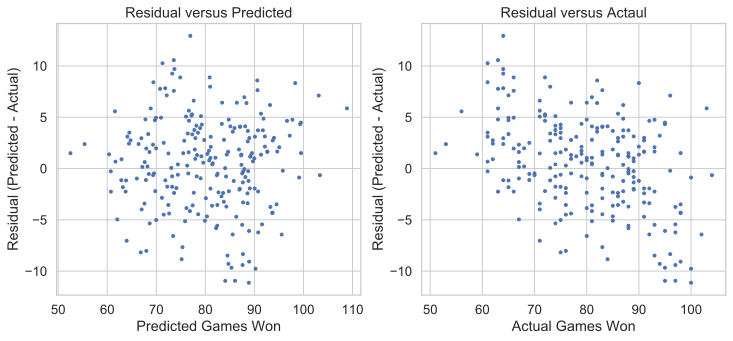

In [50]:
plt.figure(figsize=(12,5))

# plot the residuals
ax1=plt.subplot(1, 2, 1)
plt.xlabel('Predicted Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Predicted')
plt.plot(precicted_wins, win_diff, '.');

# plot the residuals
ax2=plt.subplot(1, 2, 2)
plt.xlabel('Actual Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Actaul')
plt.plot(actual_wins, win_diff, '.');

We still can't escape this negative residual trend. And although the model seems to be predicting slightly better, the fact that the coefficents are starting to make no sense and we didn't fix the residual issue lead me to back track to the model with only "engineered stats"

# Analyzing and Evaluating the Model
Now that we know which model we want to use (pure linear) and which features (pure and engineered, no polynomials) lets analyze 

In [51]:
combined_features_avgs = ['BA', 'OBP', 'SLG', 'BA_A', 'OBP_A', 'SLG_A']
features = all_games[combined_features_avgs]
target = all_games['W']

In [70]:
# create a model on all 80% of data
final_lr = LinearRegression()
final_model = final_lr.fit(features, target)
final_model.coef_, final_model.intercept_

(array([ -39.50716294,  333.71473331,  154.87838357,   47.61257099,
        -355.53307197, -153.98634016]), 85.60959977265783)

In [53]:
# Let's look at how our model scores on data it has never seen
print("Score new data: ", final_lr.score(test_seasons[combined_features_avgs], test_seasons['W']))

Score new data:  0.8048696781230293


In [54]:
# Let's see the difference between predicted vs actual wins, i.e. the residuals
win_diff = final_model.predict(test_seasons[combined_features_avgs]) - test_seasons['W']
win_diff.abs().describe()

count    230.000000
mean       3.964402
std        3.088287
min        0.028063
25%        1.462704
50%        3.180714
75%        5.832583
max       15.816441
Name: W, dtype: float64

So our model can predict the number of wins a team will have within about 4 wins on AVERAGE. With a std dev of 2.9 games, about 85% of our predictions land within 6.5 games of the actual values. These are all pretty good numbers.

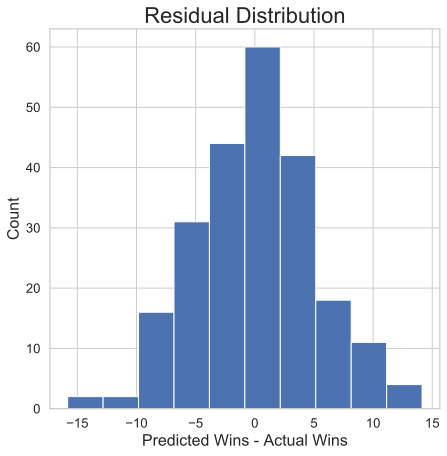

In [55]:
plt.figure(figsize=(7,7))
plt.xlabel('Predicted Wins - Actual Wins', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Residual Distribution', fontsize=22)
plt.hist(win_diff,bins=10);

We also see a pretty normal distribution of the residuals. It is centered a bit greater than zero.

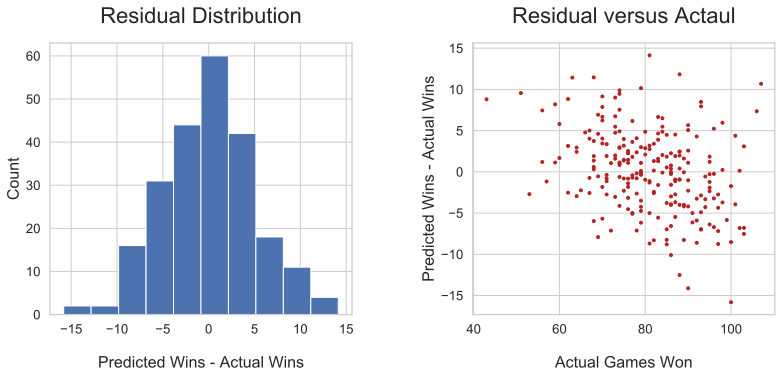

In [56]:
plt.figure(figsize=(13,5))
plt.subplots_adjust(wspace=.4)

# plot the residuals
ax1=plt.subplot(1, 2, 1)
plt.xlabel('Predicted Wins - Actual Wins',labelpad=20, fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Residual Distribution', pad=20, fontsize=22)
plt.hist(win_diff,bins=10);

# plot the residuals
ax2=plt.subplot(1, 2, 2)
plt.ylabel('Predicted Wins - Actual Wins', fontsize=16)
plt.xlabel('Actual Games Won', labelpad=20, fontsize=16)
plt.title('Residual versus Actaul', pad=20, fontsize=22)
plt.plot(test_seasons['W'], win_diff, '.', color="firebrick")
plt.savefig('residuals_avg_2.png', bbox_inches = "tight", dpi=500);

While our residuals are evenly distributed with respect to our predictions, there is still that negative trajectory when we plot it with respect to the actual values. This is something I just could not shake... Let's take one final look at what the coefficents are telling us.

In [57]:
# create a scaled model on all 80% of data
features = all_games[combined_features_avgs]
test_features = test_seasons[combined_features_avgs]
target = all_games['W']
test_target = test_seasons['W']

std = StandardScaler()
train_scale = std.fit_transform(features)
test_scale = std.transform(test_features)

final_lr_scaled = LinearRegression()
final_model_scaled = final_lr_scaled.fit(train_scale, target)

In [58]:
# scaled model score is the same as before, thats perfect
print("Score new data: ", final_lr_scaled.score(test_scale,test_target))

Score new data:  0.8048696781230291


In [59]:
for c in zip(combined_features_avgs, final_lr_scaled.coef_):
    print(c[0], c[1])

BA -0.5000540601416729
OBP 4.951042851064018
SLG 4.91640174052676
BA_A 0.6407138095780334
OBP_A -5.575137348747894
SLG_A -4.920451030497132


This is VERY interesting and is what we have been seeing throughout this notebook. BA and OBP are very similar stats, but my model shows that OBP is far more indicative of win percentage than BA. While walks may be boring, they are clearly very important!

# Applying The Model
Lets apply this model to the 2020 data

In [60]:
# take the 2020 seasons
complete_2020 = complete_df[complete_df['Year']==2020]
complete_2020;

Use my model to predict the number of wins a team will have over the next 102 games (to complete a full season)

In [61]:
# estimate the predicted wins over the next 102 games
pred_wins = final_model.predict(complete_2020[combined_features_avgs])*102/162

Create a predicted wins column which is the teams current wins plus the wins my model predicted over the next 102 games

In [62]:
complete_2020["predicted_wins"] = pred_wins + complete_2020["W"]

Create a column of extrapolated wins. Simply their current win% extrapolated over a 162 game season

In [63]:
complete_2020["extrapolated_wins"] = complete_2020["W"]*162/60

Create a column with the diofference between our projected wins and extrapolated wins

In [64]:
complete_2020["win_diff"] = complete_2020["extrapolated_wins"] - complete_2020["predicted_wins"]

In [65]:
complete_2020 = complete_2020.reset_index(drop=True)

In [66]:
# On avg a teams projected wins will land within 4.5 games of their extrapolated wins
complete_2020["win_diff"].abs().describe()

count    30.000000
mean      4.351052
std       3.513336
min       0.333012
25%       1.951152
50%       3.235780
75%       5.819195
max      13.465635
Name: win_diff, dtype: float64

Lets plot the Projected Games won over Current Games Won. The blue line represents the extrapolated wins. A team above the line has been getting "unlucky" and would expect to improve their win% as the year went on. Teams below that line have been getting "lucky" and should expect the opposite

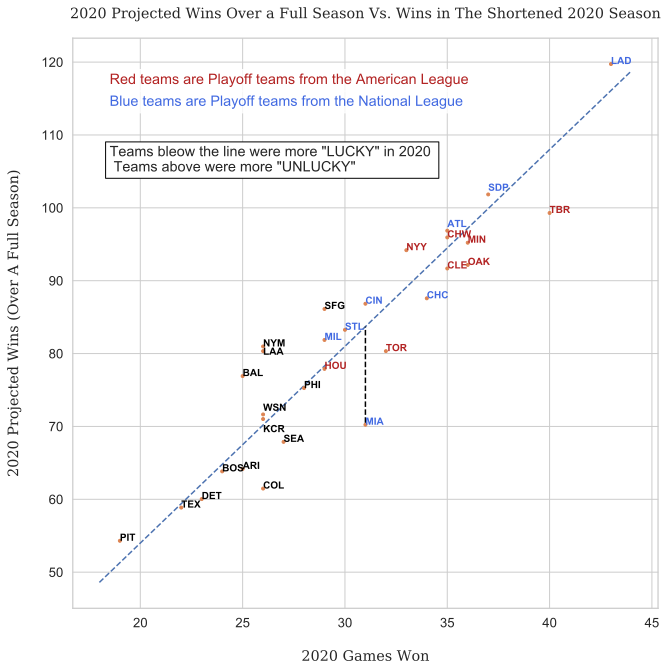

In [67]:


plt.figure(figsize=(10.5,10.5))

tred = plt.text(18.5, 117, "Red teams are Playoff teams from the American League",color='firebrick')
tred.set_bbox(dict(facecolor='white', alpha=.8))

tblue = plt.text(18.5, 114, "Blue teams are Playoff teams from the National League", color='royalblue')
tblue.set_bbox(dict(facecolor='white', alpha=.8))

t1 = plt.text(18.5, 105, 'Teams below the line were more "LUCKY" in 2020 \n Teams above were more "UNLUCKY"', )
t1.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

plt.xlabel("2020 Games Won", family='serif', labelpad=20 )
plt.ylabel("2020 Projected Wins (Over A Full Season)", family='serif', labelpad=20 )
plt.title("2020 Projected Wins Over a Full Season Vs. Wins in The Shortened 2020 Season", family='serif', pad=20)
plt.plot(range(18,45), [(x*162/60) for x in range(18,45)], ls='--')
plt.plot(complete_2020["W"], complete_2020["predicted_wins"], '.')
plt.plot([31,31],[70.5, 83.7], '--' , color="black")

for i, txt in enumerate(complete_2020["Team"]):
    y_buffer = 0
    color = "black"
    playoff_teams = ["CHW", "MIN", "CLE", "LAD", "SDP", "TBD", "ATL", "NYY", 
                     "OAK", "CIN", "CHC", "FLA", "STL", "MIL", "HOU", "TOR"]
    benefitted_teams = ["CLE", "TOR", "HOU", "STL", "MIL", "FLA"]
    
    american_league = ["CHW", "MIN", "CLE", "TBD", "NYY", "OAK", "HOU", "TOR"]
    national_league = ["LAD", "SDP", "ATL", "CIN", "CHC", "FLA", "STL", "MIL"]
    
    
    if txt in american_league:
        color="firebrick"
    if txt in national_league:
        color="royalblue"
        
    if txt == "FLA":
        txt = "MIA"
    if txt == "TBD":
        txt = "TBR"
    elif txt == "ANA":
        txt = "LAA"
        y_buffer = -.5
    elif txt== "WSN":
        y_buffer = .5
    elif txt=="KCR":
        y_buffer = -1.8
    elif txt=="ATL":
        y_buffer = .5
    elif txt=="SDP":
        y_buffer = .5
    plt.annotate(txt, (complete_2020["W"][i], complete_2020["predicted_wins"][i]+y_buffer), 
                 fontsize=10, color=color, fontweight="bold")
# plt.savefig('final_plot.png', bbox_inches = "tight", dpi=500);

# What Does This Tell US?

- Teams above the line had been "under-preforming" their stats through the first 60 games and would expect to "progress" if the season were allowed to continue

- Teams below the line were "over-preforming" their stats and we would expect them to "regress" as the seaso. continues

- The Marlins were the "luckiest" team of 2020, they finished the season with a winning record and made the playoffs. If the season were 162 games my model would have them not only missing the playoffs, but finishing the season with a losing record.

- The Dodgers were projected to break the record of most wins in an MLB season